In [1]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Input

Load Dataset

In [3]:
import data_processing as dp

#img_size = 64
#color_mode = 'grayscale'
#max_image_per_class = None

#(X_train, X_test, y_train, y_test), reverse_map = dp.load_asl_alphabet_dataset(img_size=64)
#(X_train, X_test, y_train, y_test), reverse_map = dp.load_asl_alphabet_dataset(img_size=64, color_mode='grayscale')

(X_train, y_train), (X_val, y_val), (X_test, y_test), reverse_map = dp.load_asl_alphabet_dataset1(
    img_size=64,
    color_mode='grayscale'
)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")


Train shape: (60900, 64, 64, 1), Validation shape: (17400, 64, 64, 1), Test shape: (8700, 64, 64, 1)


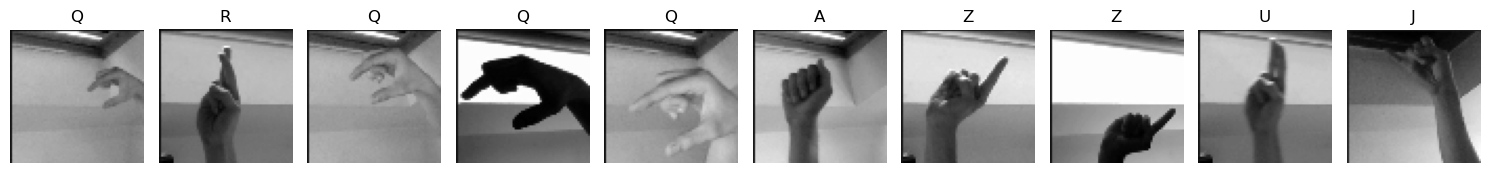

In [4]:
import matplotlib.pyplot as plt
def show_samples(X, y, reverse_map, num_samples):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X[i].reshape(X.shape[1], X.shape[2]), cmap='gray')
        plt.title(reverse_map[y[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
show_samples(X_train, y_train, reverse_map, num_samples = 10)

CNN model

In [5]:
from tensorflow.keras.optimizers import Adam

input_shape = (64, 64, 1)
num_classes = 29

def build_cnn():
    model = Sequential()
    model.add(Input(shape=input_shape))

    # 1st conv block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.15))

    # 2nd conv block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.15))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=3e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [6]:
#from tensorflow.keras.utils import plot_model

# Save architecture diagram as a PNG
#plot_model(model, to_file="asl_cnn_architecture.png", show_shapes=True, show_layer_names=True)

model = build_cnn()

model.summary()

2025-07-28 22:12:27.234800: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-07-28 22:12:27.234840: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-07-28 22:12:27.234854: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-07-28 22:12:27.234878: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-28 22:12:27.234906: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         1,885 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,069,725 (4.08 MB)

 Trainable params: 1,069,533 (4.08 MB)

 Non-trainable params: 192 (768.00 B)

In [7]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("./model/cnn.keras", save_best_only=True)

# Train
history = model.fit(
    X_train, y_train,
    batch_size=32,
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/10


2025-07-28 22:12:28.959202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-07-28 22:12:28.964027: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1904/1904 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1147 - loss: 3.1083

2025-07-28 22:13:39.997683: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1904/1904 ━━━━━━━━━━━━━━━━━━━━ 77s 40ms/step - accuracy: 0.1147 - loss: 3.1082 - val_accuracy: 0.3277 - val_loss: 2.2538
Epoch 2/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 73s 39ms/step - accuracy: 0.3441 - loss: 2.0762 - val_accuracy: 0.6716 - val_loss: 0.9731
Epoch 3/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 73s 38ms/step - accuracy: 0.5465 - loss: 1.3171 - val_accuracy: 0.7378 - val_loss: 0.7231
Epoch 4/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 73s 39ms/step - accuracy: 0.6737 - loss: 0.9244 - val_accuracy: 0.8428 - val_loss: 0.4237
Epoch 5/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 74s 39ms/step - accuracy: 0.7440 - loss: 0.7034 - val_accuracy: 0.9237 - val_loss: 0.2437
Epoch 6/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 74s 39ms/step - accuracy: 0.8006 - loss: 0.5580 - val_accuracy: 0.9453 - val_loss: 0.1798
Epoch 7/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 74s 39ms/step - accuracy: 0.8348 - loss: 0.4580 - val_accuracy: 0.9247 - val_loss: 0.2120
Epoch 8/10
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 74s 39ms/step - accuracy: 0.8598 - loss: 0.38

Evaluate

In [8]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)
print(f"CNN Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

544/544 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9691 - loss: 0.0968
CNN Validation Accuracy: 0.9696, Loss: 0.0966


Plot Accuracy and Loss

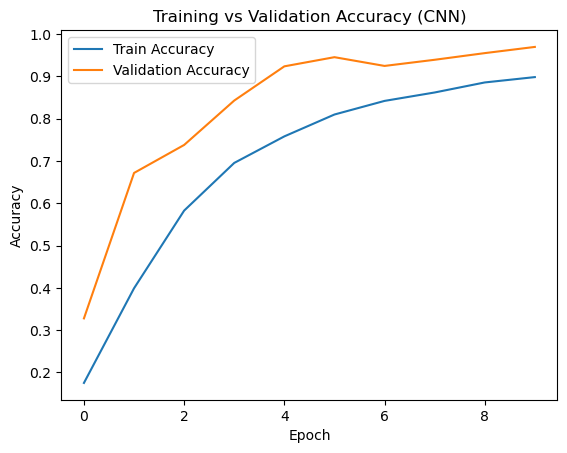

In [9]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy (CNN)")
plt.show()

In [10]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"CNN Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")

272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9667 - loss: 0.1028
CNN Test Accuracy: 0.9668, Loss: 0.1036


2025-07-28 22:25:13.381603: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


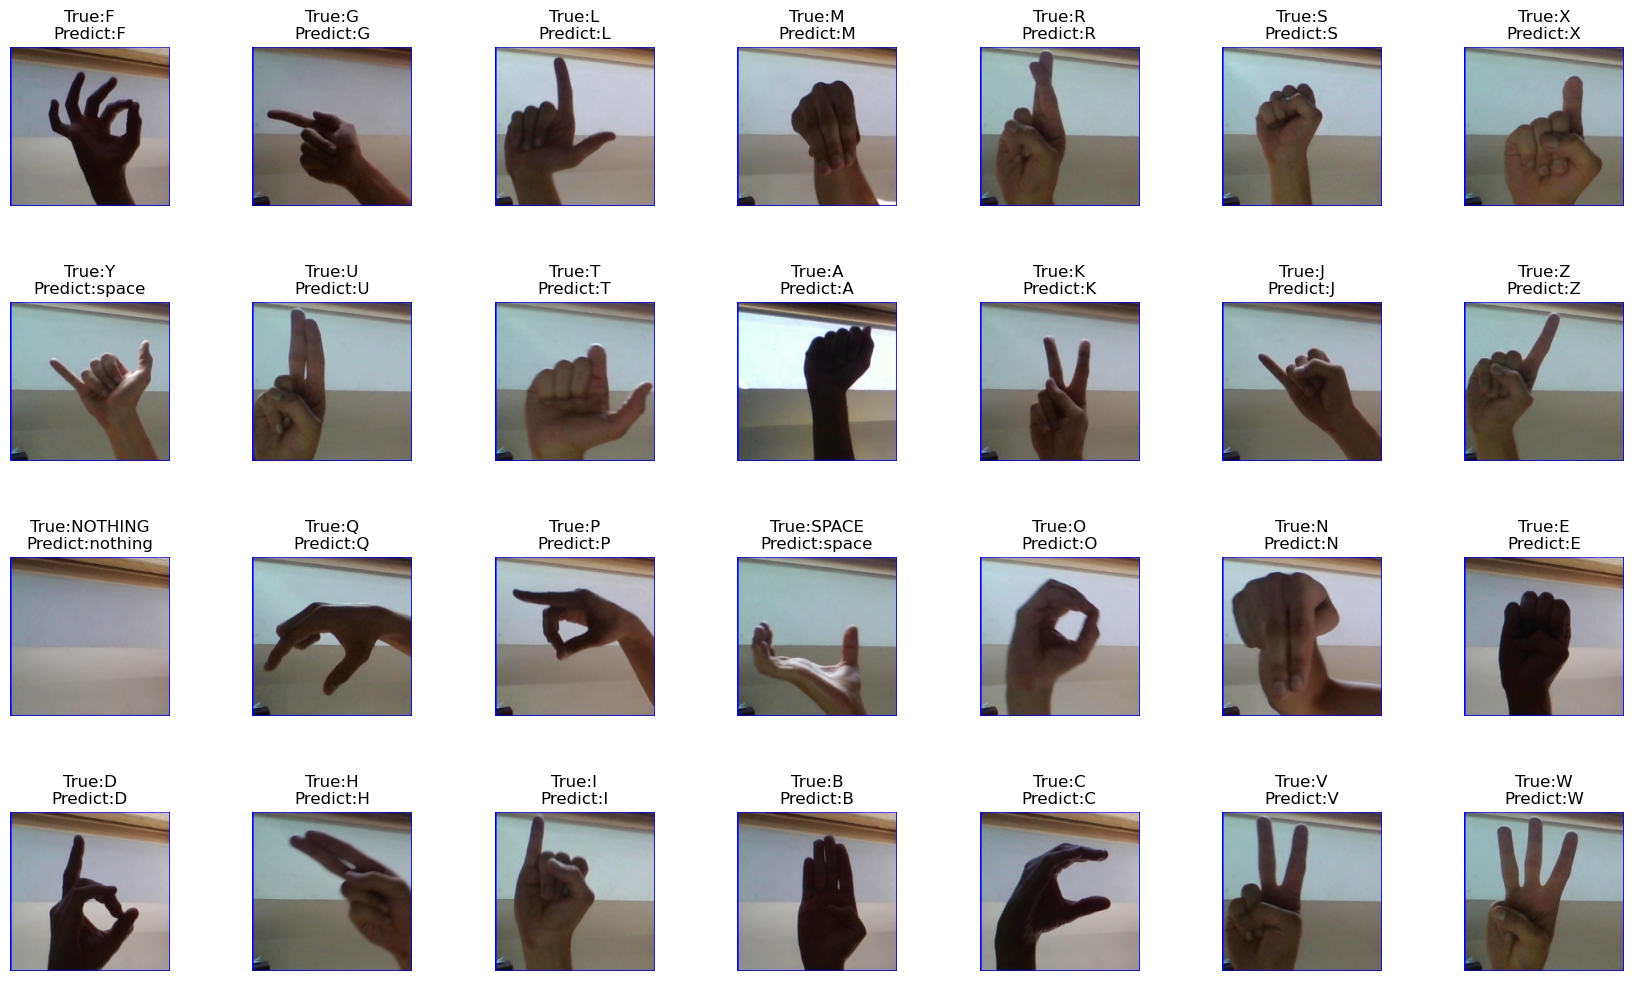

In [11]:
def evaluate_on_test_folder(model, test_dir, img_size, reverse_map, N=None):
    results = []
    
    all_files = [
        (os.path.splitext(f)[0].split("_")[0].strip().upper(), os.path.join(test_dir, f))
        for f in os.listdir(test_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    
    if N:
        all_files = all_files[:N]
    
    for true_label, img_path in all_files:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size)).astype("float32") / 255.0
        img_input = img.reshape(1, img_size, img_size, 1)
        
        pred = model.predict(img_input, verbose=0)
        pred_class = np.argmax(pred)
        pred_label = reverse_map[pred_class]
        
        results.append({
            "True Label": true_label,
            "Predicted Label": pred_label
        })
    
    # Display grid
    images_per_row = 7
    num_images = len(results)
    num_rows = math.ceil(num_images / images_per_row)
    
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(3 * images_per_row, 3 * num_rows))
    axes = axes.flatten()

    for i in range(len(axes)):
        ax = axes[i]
        if i < num_images:
            img_disp = cv2.imread(all_files[i][1])
            img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)
            ax.imshow(img_disp)
            ax.set_title(f"True:{results[i]['True Label']}\nPredict:{results[i]['Predicted Label']}", fontsize=12)
        ax.axis('off')
    
    plt.subplots_adjust(wspace=0.4, hspace=0.6)  # 👈 Adds gaps between columns (wspace) and rows (hspace)
    plt.show()

    return results


test_dir = "./data/asl_alphabet_test"  
results_cnn = evaluate_on_test_folder(model, test_dir, img_size=64, reverse_map=reverse_map)

In [12]:
# Compute accuracy
correct = sum(1 for r in results_cnn if r["True Label"] == r["Predicted Label"])
accuracy = correct / len(results_cnn) if results_cnn else 0
print(f"CNN : Test accuracy: {accuracy:.4f}")

CNN : Test accuracy: 0.8929


Confusion Matrix

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd

# Predict labels
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Binary: 1 if prediction is correct, 0 if incorrect
y_true_binary = (y_pred == y_test).astype(int)
y_pred_binary = np.ones_like(y_true_binary)  # pretend all predictions are "True" to align with comparison

# Now confusion matrix for correct vs incorrect predictions
cm_binary = confusion_matrix(y_true_binary, y_pred_binary)

# Format as 2x2 table
cm_df = pd.DataFrame(cm_binary,
                     index=["Actually Incorrect", "Actually Correct"],
                     columns=["Predicted Incorrect", "Predicted Correct"])

print("Confusion Matrix:")
display(cm_df)

272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Confusion Matrix:


,Predicted Incorrect,Predicted Correct
Actually Incorrect,0,289
Actually Correct,0,8411


In [14]:
from sklearn.metrics import classification_report, f1_score

# Print precision, recall, f1-score for each class
print(classification_report(y_test, y_pred, digits=4))

# Optional: get macro/micro F1 score only
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"F1 Macro:    {f1_macro:.4f}")
print(f"F1 Micro:    {f1_micro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")

              precision    recall  f1-score   support

           0     0.9416    0.9797    0.9603       296
           1     0.9627    0.9726    0.9676       292
           2     0.9968    0.9968    0.9968       316
           3     0.9822    0.9892    0.9857       279
           4     0.9743    0.8439    0.9044       314
           5     1.0000    0.9632    0.9813       299
           6     0.9831    0.9898    0.9864       293
           7     0.9892    0.9892    0.9892       277
           8     0.8994    0.9967    0.9456       305
           9     0.9841    0.9904    0.9872       312
          10     0.9425    1.0000    0.9704       295
          11     0.9966    1.0000    0.9983       290
          12     0.9966    0.9325    0.9635       311
          13     0.9388    0.9969    0.9670       323
          14     0.9968    0.9809    0.9888       314
          15     1.0000    0.9929    0.9964       281
          16     0.9929    1.0000    0.9964       278
          17     0.9067    